In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms
from model import LBPModel
# from loss import LBPloss

from tqdm import tqdm



In [2]:
df = pd.read_csv('../data/df.csv')
df['label_id'] = df.label.apply( lambda x : 0.)
df_data = df.groupby('path')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    
    data  = df_data.get_group(img_id)
#     boxes = data['bbox'].values
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
#     labels = data['label'].values
    return dict(image_id = img_id, boxes = boxes)
#     return dict(image_id = img_id, boxes = boxes, labels=labels)

train_list = [get_data(img_id) for img_id in df.path.unique()]
# df.head()
train_list[0]

{'image_id': 'patch_images/2021.01.08/LBC141-20210105(1)/LBC141-20210105(1)_1001.png',
 'boxes': array([[1558., 1603.,   96.,   73.,    0.],
        [1452., 1263.,   82.,   94.,    0.]])}

In [3]:
path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
file_list[:2]

test_list = [get_data(img_id) for img_id in file_list]
test_list[:2]

[{'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
  'boxes': []},
 {'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png',
  'boxes': []}]

In [4]:
BATCH_SIZE = 32
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=2,
    num_workers=2,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [5]:
# next(iter(train_dataset))

In [6]:
p = torch.tensor([[3.3105e-01],
        [8.0981e-01],
        [9.6460e-01],
        [8.4326e-01],
        [8.4961e-01]])
l = torch.tensor([[1.,1.,1.,1.,1.]])

-(l * torch.log(p)) 
(1. - l) * torch.log(1. - p).sum()

tensor([[-0., -0., -0., -0., -0.]])

In [7]:
class LBPloss(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        self.device = device

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target):
        # Check where obj and noobj (we ignore if target == -1)
        
        cell_pred = predictions[:,:,0]
        ab_cell_pred = predictions[:,:,1]
        
        cell_label = target[:,:,0]
        ab_cell_label = target[:,:,1]
#         print('cell label',cell_label.shape)
#         print('cell pred',cell_pred.shape)

        batch_size, _ = cell_pred.shape
#         losses = []
        bce = []
        cell_loss = []
        bce_ab = []
        
        cell_label[(cell_label >= 0.) & (cell_label < 0.2)] = 0
        cell_label[(cell_label >= 0.2) & (cell_label < 0.6)] = -1
        cell_label[(cell_label >= 0.6)] = 1        

        for j in range(batch_size) :
#             cell_pred_j = cell_pred[j]
#             ab_cell_pred_j = ab_cell_pred[j]
            
#             cell_label_j = cell_label[j]
#             ab_cell_label_j = ab_cell_label[j]
        

    #         print(cell_label)
    #         print(cell_pred)

            # bce for normal cell
#             print(-(cell_label[j] * torch.log(cell_pred[j]) + (1. - cell_label[j]) * torch.log(1. - cell_pred[j]) ))
            bce.append(-(cell_label[j] * torch.log(cell_pred[j] + 1e-8) + (1. - cell_label[j]) * torch.log((1. - cell_pred[j]) + 1e-8)))
            cell_loss.append(torch.where(torch.ne(cell_label[j], -1.), bce[j], torch.zeros(bce[j].shape).to(self.device)))

            # bce for abnormal cell
            bce_ab.append( -(ab_cell_label[j] * torch.log(ab_cell_pred[j] + 1e-8) + 
                             (1. - ab_cell_label[j]) * torch.log((1. - ab_cell_pred[j]) + + 1e-8 )))

#             print('cell_loss', cell_loss.mean())
    #         print(bce_ab.mean())
#             losses.append(cell_loss.mean() + bce_ab.mean())
#         print(torch.stack(cell_loss).mean())
#         for i in range(batch_size) :
#             if torch.isnan(cell_loss[i]) :
#                 print(cell_loss[i])

        return torch.stack(bce_ab).mean() + torch.stack(cell_loss).mean(), cell_loss

In [8]:
device = torch.device('cuda')
model = LBPModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4 )
loss_fn = LBPloss(device).to(device)
scaler = torch.cuda.amp.GradScaler()

In [9]:
epochs = 20
for epoch in (range(epochs)) :
    batch_losses = []
    loop = tqdm(train_loader, leave=True)
    count = 0
    for image, iou, targets, path in loop :

        batch_size, gride_size, _ = iou.shape
        image = image.permute(0,3,1,2).to(device)
#         with torch.cuda.amp.autocast():
        with torch.autograd.set_detect_anomaly(True) :
            outputs = model(image)
            iou = iou.view(batch_size, gride_size*gride_size, -1)
            targets = targets.view(batch_size, gride_size*gride_size, -1)
            labels = torch.cat([iou, targets], dim=-1)
            labels = labels.to(device)
            loss, cell_loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
    #         scaler.scale(loss).backward()
    #         scaler.step(optimizer)
    #         scaler.update()

            mean_loss = sum(batch_losses) / len(batch_losses)
            loop.set_postfix(loss=mean_loss) 
            count += 1


100%|██████████| 13/13 [00:11<00:00,  1.16it/s, loss=0.176]


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = list(map(int, bbox))
#     print(bbox)
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
#     print((int(x_min), int(y_min)), (int(x_max), int(y_max)))

    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=BOX_COLOR, thickness=thickness)
    return img

def visualize(image, bboxes):
    img = image.copy()
    print(img.shape)
#     img = image.clone().detach()
    for bbox in (bboxes):
#         print(bbox)
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [57]:
# images, _, _ = next(iter(test_loader))
images, iou, _ = next(iter(train_loader))
print(images.shape)
images = images.permute(0,3,1,2).to(device)
# image = image.to(device)
outputs = model(images)

torch.Size([32, 512, 512, 3])


In [58]:
# print(outputs.shape)
# iou[0] > 0.8

In [59]:
# (outputs.view(2,15,15,2)[1,:,:,0] >= 0.999).sum()
print((outputs.view(BATCH_SIZE,15,15,2)[1,:,:,0] > 0.9).sum() )
print((outputs.view(BATCH_SIZE,15,15,2)[1,:,:,1] > 0.9).sum() )
print(torch.max(outputs.view(BATCH_SIZE,15,15,2)[0,:,:,1]))
print(torch.max(outputs.view(BATCH_SIZE,15,15,2)[1,:,:,1]))
print(torch.max(outputs.view(BATCH_SIZE,15,15,2)[2,:,:,1]))


tensor(88, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.2221, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1985, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2035, device='cuda:0', grad_fn=<MaxBackward1>)


In [61]:
# print(outputs.view(2,15,15,2)[1,:,:,0])
# print(outputs.view(2,15,15,2)[1,:,:,1])
# outputs.view(2,15,15,2)[1,:,:,0] > 0.5
# torch.ge(outputs.view(2,15,15,2)[1,:,:,0], 0.5)
# positive_indices[positive_indices==True]
# a, b = (outputs.view(BATCH_SIZE,15,15,2)[0,:,:,0] >= 0.9).cpu().detach().nonzero(as_tuple=True)
a, b = (outputs.view(BATCH_SIZE,15,15,2)[0,:,:,1] >= 0.2).cpu().detach().nonzero(as_tuple=True)
# a, b = (iou.view(BATCH_SIZE,15,15)[0,:,:] >= 0.7).cpu().detach().nonzero(as_tuple=True)
bboxes = []
for x, y in zip(a, b) :
#     print(int(x), int(y))
    xmin = int(x) * 32
    xmax = xmin + 64
    ymin = int(y) * 32
    ymax = ymin + 64
    bboxes.append([xmin, ymin, xmax, ymax])
bboxes    

[[0, 32, 64, 96],
 [32, 192, 96, 256],
 [96, 0, 160, 64],
 [128, 32, 192, 96],
 [128, 64, 192, 128],
 [160, 256, 224, 320],
 [320, 0, 384, 64]]

In [44]:
# outputs.view(2,15,15,2)[1,:,:,1] > 0.5

In [45]:
images[0].permute(1,2,0)

tensor([[[ 0.8353,  0.7961,  0.8039],
         [ 0.8510,  0.8118,  0.8196],
         [ 0.8353,  0.8039,  0.8118],
         ...,
         [ 0.5059,  0.3804,  0.3412],
         [ 0.5686,  0.4588,  0.4431],
         [ 0.5294,  0.4667,  0.4745]],

        [[ 0.8510,  0.8118,  0.8196],
         [ 0.8510,  0.8118,  0.8196],
         [ 0.8353,  0.8118,  0.8118],
         ...,
         [ 0.2471,  0.1216,  0.0824],
         [ 0.4275,  0.3569,  0.3490],
         [ 0.2941,  0.1922,  0.2392]],

        [[ 0.8431,  0.8039,  0.8118],
         [ 0.8588,  0.8196,  0.8275],
         [ 0.8431,  0.8118,  0.8196],
         ...,
         [ 0.2471,  0.0980,  0.0980],
         [ 0.2941,  0.2235,  0.2471],
         [-0.0353, -0.2235, -0.1294]],

        ...,

        [[ 0.7098,  0.6392,  0.5843],
         [ 0.6627,  0.5922,  0.5373],
         [ 0.6706,  0.6000,  0.5451],
         ...,
         [ 0.6941,  0.6314,  0.5451],
         [ 0.6549,  0.5922,  0.5373],
         [ 0.6784,  0.6314,  0.5529]],

        [[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


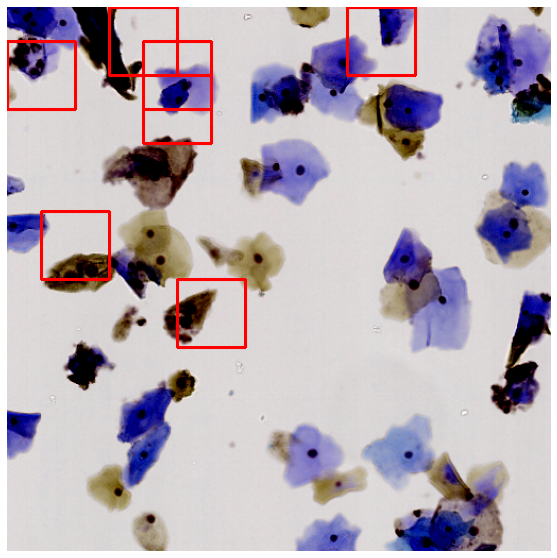

In [62]:
visualize(images[0].permute(2,1,0).cpu().detach().numpy(), bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


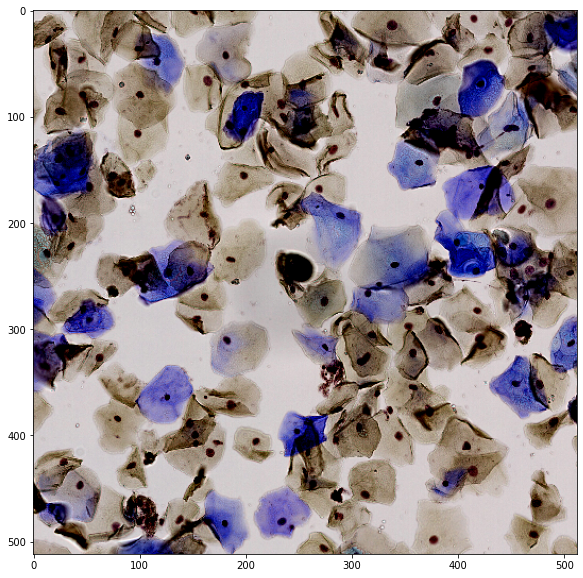

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0].permute(2,1,0).cpu().detach().numpy())